# Tic Tac Toe - An example of reinforcement learning

See https://dsiag.ch/blog/2020-09-01-reinforcement-learning for details and explanation


In [2]:
import random
AGENT = 1
OPPONENT = -1
NO_PLAYER = 0

##  Game Model

In [3]:
class Game:    
    def __init__(self, game_state=None):
        if game_state is None:
            game_state = [
                0, 0, 0,
                0, 0, 0,
                0, 0, 0
            ]
        self.state = game_state
    
    def __str__(self):
        return str(self.state)

    def is_draw(self):
        return len([field for field in self.state if field == NO_PLAYER]) == 0

    def is_finished(self):
        return self.get_winner() != NO_PLAYER or self.is_draw()

    def valid_moves(self):
        return [i for i in range(9) if self.state[i] == NO_PLAYER]

    def make_move(self, field, player):
        next = list(self.state)
        next[field] = player
        return Game(next)

    def get_winner(self):
        state = self.state
        for i in range(3):
            if state[i * 3] == state[i * 3 + 1] == state[i * 3 + 2] == state[i * 3] != NO_PLAYER:
                return state[i * 3]
            if state[i] == state[i + 3] == state[i + 6] == state[i] != NO_PLAYER:
                return state[i]
            if state[0] == state[4] == state[8] == state[0] != NO_PLAYER:
                return state[0]
            if state[2] == state[4] == state[6] == state[2] != NO_PLAYER:
                return state[2]

        return NO_PLAYER

In [4]:
def play_games(policy, opponent_policy, num_games=100):
    games_won = 0
    draw = 0
    # Play games
    for i in range(num_games):
        game = Game()
        # 50% chance opponent starts
        if random.random() > 0.5:
            game = game.make_move(opponent_policy(game), OPPONENT)

        while not game.is_finished():
            # First players turn
            game = game.make_move(policy(game), AGENT)
            if game.is_finished():
                break
            # Other players turn
            game = game.make_move(opponent_policy(game), OPPONENT)

        if game.get_winner() == 0:
            draw = draw + 1
        if game.get_winner() > 0:
            games_won = games_won + 1

    return games_won, draw

## Reward function

In [5]:
def reward(game):
    return max(game.get_winner(), 0)

## Policies

### Table values

In [6]:
class ValuePolicy:
    DEFAULT_VALUE = 0.5

    def __init__(self):
        self.values = {}

    def policy(self, game):
        move_values = {}
        moves = game.valid_moves()
        for move in moves:
            next = game.make_move(move, AGENT)
            move_values[move] = self.get_state_value(next)

        return max(move_values, key=move_values.get)

    def get_state_value(self, state):
        if str(state) not in self.values:
            return self.DEFAULT_VALUE

        return self.values[str(state)]

    def set_state_value(self, state, value):
        self.values[str(state)] = value

    def learn(self, states):
        # Actually perform the learning
        def temporal_difference(current_state_value, next_state_value):
            learning_rate = 0.1
            return current_state_value + learning_rate * (next_state_value - current_state_value)

        last_state = states[-1:][0]
        last_value = reward(last_state)
        self.set_state_value(last_state, last_value)
        # Got through every state from end to start
        for state in reversed(states[:-1]):
            value = self.get_state_value(state)
            last_value = temporal_difference(value, last_value)
            self.set_state_value(state, last_value)

### Random 

In [7]:
def random_policy(game):
    return random.choice(game.valid_moves())

## Training function

In [8]:
def train(policy, opponent_policy, training_games=1000):
    for i in range(training_games):
        game = Game()
        states = []

        # 50% chance opponent starts
        if random.random() > 0.5:
            game = game.make_move(opponent_policy(game), OPPONENT)

        while not game.is_finished():
            # Our agent makes a move
            # but occasionally we make a random choice
            if random.random() < 0.5:
                game = game.make_move(random_policy(game), AGENT)
            else:
                game = game.make_move(policy.policy(game), AGENT)
            states.append(game)

            if game.is_finished():
                break

            game = game.make_move(opponent_policy(game), OPPONENT)
            states.append(game)

        policy.learn(states)

## Train and run the reinforcement learning 

In [9]:
policy = ValuePolicy()

train(policy, random_policy, training_games=1000)

games_to_play = 2000
games_won, draw = play_games(policy.policy, random_policy, games_to_play)

print("Games played: %s" % games_to_play)
print("Games won: %s" % games_won)
print("Draw: %s" % draw)

Games played: 2000
Games won: 1366
Draw: 124


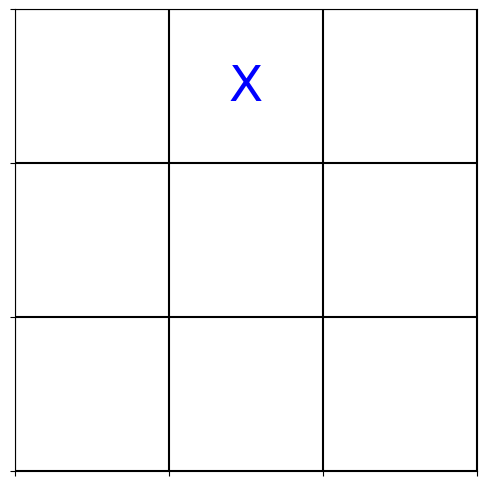

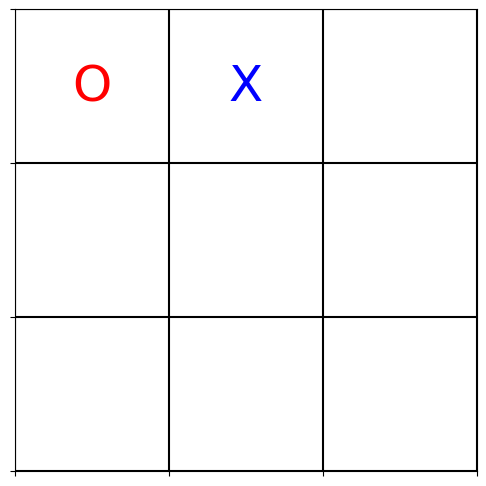

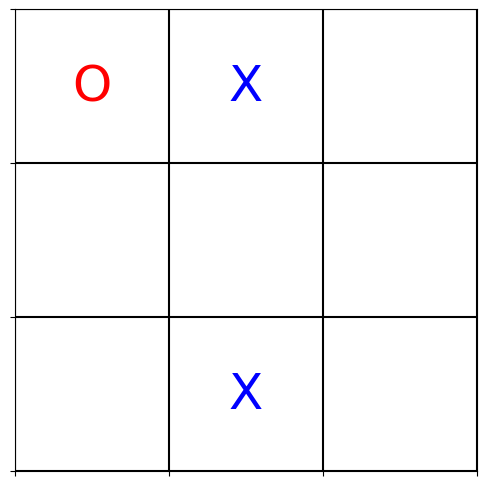

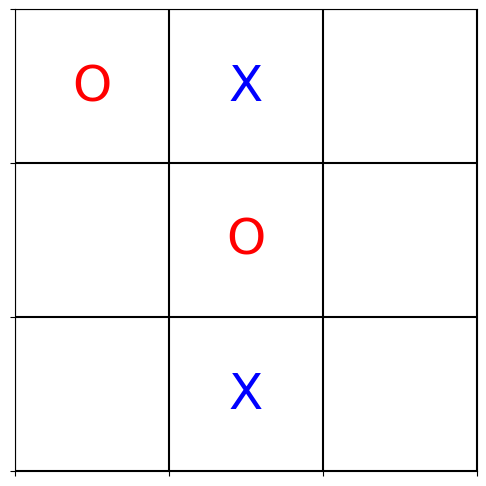

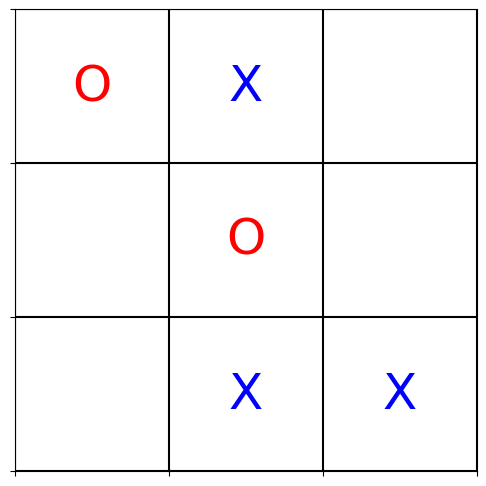

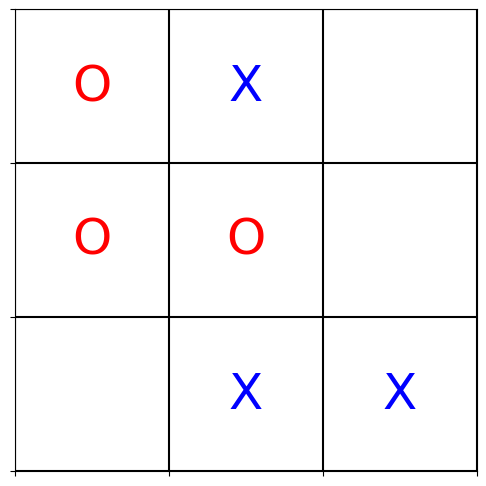

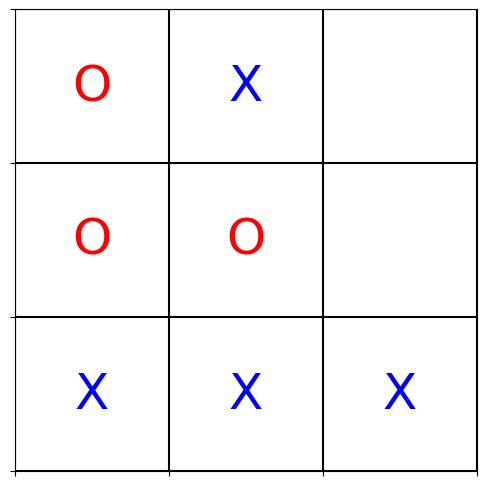

Agent kazandı!


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Görselleştirme fonksiyonu
def plot_game_state(state):
    """
    Oyun durumunu bir grafikle görselleştirir.
    :param state: 9 elemanlı bir liste (0: boş, 1: X, -1: O)
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(np.arange(-0.5, 3, 1))
    ax.set_yticks(np.arange(-0.5, 3, 1))
    ax.grid(which="major", color="black", linewidth=1.5)
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

    # Tahtayı çiz
    for i in range(9):
        x = i % 3
        y = 2 - (i // 3)  # Matplotlib'de y ekseni ters
        if state[i] == AGENT:
            ax.text(x, y, 'X', fontsize=36, ha='center', va='center', color='blue')
        elif state[i] == OPPONENT:
            ax.text(x, y, 'O', fontsize=36, ha='center', va='center', color='red')

    plt.show()

# Eğitim süreci
policy = ValuePolicy()
train(policy, random_policy, training_games=1000)

# Eğitim sonrası bir oyunun görselleştirilmesi
game = Game()
while not game.is_finished():
    # Agent'ın hamlesi
    game = game.make_move(policy.policy(game), AGENT)
    plot_game_state(game.state)  # Hamleyi görselleştir

    if game.is_finished():
        break

    # Rakibin (Random Policy) hamlesi
    game = game.make_move(random_policy(game), OPPONENT)
    plot_game_state(game.state)  # Hamleyi görselleştir

# Sonuç
if game.get_winner() == AGENT:
    print("Agent kazandı!")
elif game.get_winner() == OPPONENT:
    print("Rakip kazandı!")
else:
    print("Berabere!")


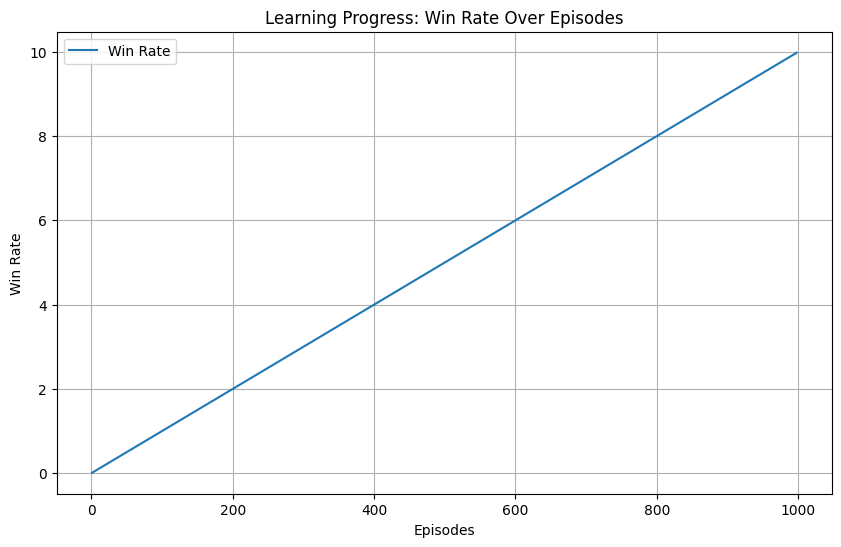

In [13]:

import matplotlib.pyplot as plt

# Assuming 'episodes' and 'win_rates' are tracked during training
# Example dummy data for demonstration
episodes = list(range(1, 999))  # Replace with actual episode numbers
win_rates = [i/100 for i in range(1, 999)]  # Replace with actual win rates

# Plotting learning curve
plt.figure(figsize=(10, 6))
plt.plot(episodes, win_rates, label='Win Rate')
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.title('Learning Progress: Win Rate Over Episodes')
plt.legend()
plt.grid()
plt.show()

# Q-table visualization suggestion
# Assuming 'q_table' is the Q-learning table, you can visualize it like this:
# import seaborn as sns
# import pandas as pd
# q_df = pd.DataFrame(q_table)  # Convert Q-table to a DataFrame
# sns.heatmap(q_df, annot=True, cmap="YlGnBu")
# plt.title('Heatmap of Q-table')
# plt.show()
